## Part A: Data Access 


# Abstract
Medical Algorithms are increasingly more important for hospitals as they attempt to systematically assist patients with greater health needs. However, with the quick adoption of algorithms that can have potentially dramatical  consequences, its important for researchers to ensure there is no mal-practice and significant bias. Obermeyer et al. (2019) sought to analyze inherent racial bias in a commerical algorithm used by the health care system. This blog post examines this analysis in order to validate the findings of Obermeyer et. Al. Through graphics and Linear Regression, we find four major insights: Black patients are sicker than White patients, White patients have higher medical expenditures, Black Patients receive lower risk scores, and Black Female patients receive the lowest risk scores. With this information, we solidify the findings of Obermeyer et al. (2019) that medical expenditure serves as a proxy for risk score assignment by this algorithm

In [2]:
import pandas as pd 
import numpy as np
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)

### Part B: Visualizing our data
Few things are as powerful as a good graph. Below I take look at the relation between risk scores and mean number of chronic relations, separated by gender. 

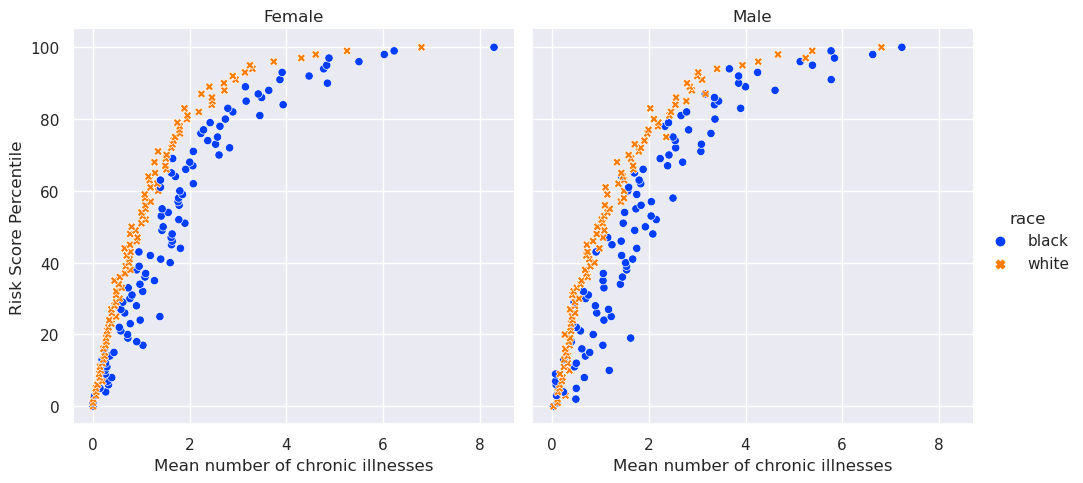

In [3]:
import seaborn as sns 
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
sns.set_palette("bright")
sns.set_context("notebook")
df['risk_score_percentile'] = (df['risk_score_t'].rank(pct=True).round(2)) * 100

#here we relabel the values in dem_female to Male and Female 
df["sex"] = np.where(df['dem_female']==0, "Male", "Female")
figure1_data = df.groupby(["risk_score_percentile", "race","sex"])["gagne_sum_t"].mean().reset_index()

# we use a relplot for our two plots to be next to one another
figure1 = sns.relplot(data=figure1_data, x="gagne_sum_t", y="risk_score_percentile", col="sex", style="race", hue="race") 
figure1.set_titles(col_template="{col_name}") #differentiate by Male or Female
#set our labels
figure1.set_axis_labels("Mean number of chronic illnesses" ,"Risk Score Percentile")

There are quite a few things to notice. The most striking is that when White patients and Black patients have the same number of illnesses, White patients tend to have a higher risk score. It also appears that Black female patients are the sickest population in this dataset. In addition to this, most people have 4 or less chronic illnesses on average.

### Part C: Visualizing our data (difficulty: 1000)
As we continue to explore our data, we are going to look at one of the key features of this dataset, total medical expenditure. This is the value that Obermeyer et al. (2019) indicate serves as a proxy for race.

Text(0.5, 0, 'Number of Chronic Illnesses')

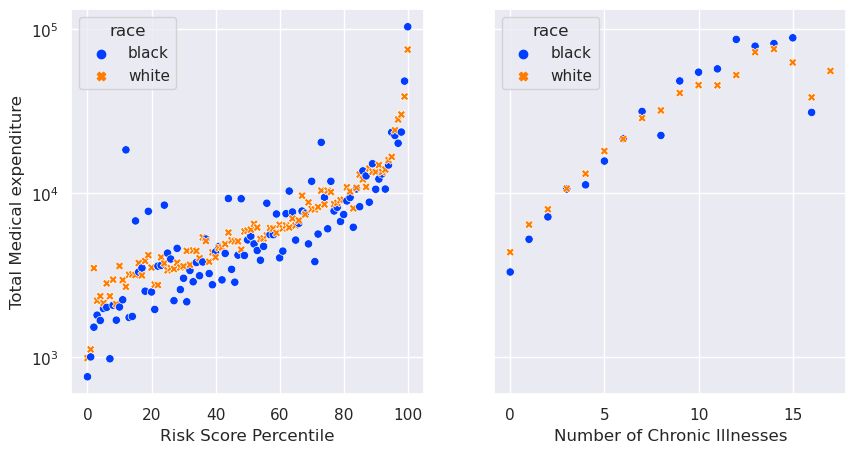

In [4]:
from matplotlib.ticker import ScalarFormatter
sns.set_style("darkgrid")
sns.set_palette("bright")

#we convert our risk_score to percentile
df['risk_score_percentile'] = (df['risk_score_t'].rank(pct=True).round(2)) * 100

#we create our first figure
figure_3a_data= df.groupby(["risk_score_percentile", "race"])['cost_t'].mean().reset_index()
sns.set_style("darkgrid")
sns.set_palette("bright")

#we create our second figure 
figure_3b_data = df.groupby(["gagne_sum_t", "race"])["cost_t"].mean().reset_index()

#This positions our plots next to each other and sets their sizes
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharey=True)

#here we plot our figures with our yscaled to a log
figure3a = sns.scatterplot(data=figure_3a_data, y="cost_t", x="risk_score_percentile", hue="race", style="race", ax=axes[0], sizes = 3)#sizes=(1400))
figure3b = sns.scatterplot(data=figure_3b_data, y="cost_t", x="gagne_sum_t", hue="race", style="race", ax=axes[1], sizes = 3)
figure3a.set(yscale="log",)
figure3b.set(yscale="log",)



#here we set our labels
axes[0].set_xlabel("Risk Score Percentile")
axes[0].set_ylabel("Total Medical expenditure")
axes[1].set_xlabel("Number of Chronic Illnesses")



Immediately, it is clear that Black patients on average, spend less than White patients. *I wonder if this stems in part from a cultural aversion to spending money at the hosptial. Coming from a family of immigrants, my family does like spending money at the hospital.*  Continuing to discuss, the graph on the right shows something very interesting. Above 5 chronic illnesses, Black patients often have higher total medical expenditures. However, as we saw in our previous graph in Part A, there are very few people with more than 5 chronic illnesses.

# Part D: Modeling Cost Disparity! 
Before we model, we weant to do a bit of data preparation

1. Lets determine the percentage of patients with fewer than 5 chronic conditions

In [5]:
below_5 = np.count_nonzero(df['gagne_sum_t']<=5)
total_column_length = np.shape(df['gagne_sum_t'])[0]
percentage = (below_5/ (total_column_length)) * 100
percentage


95.53952115447689

2. Create a log of the cost 

and  

3. Create a dummy one-hot encoded column for 0 being white and 1 meaning black


In [6]:
df_ = df.copy()

# Remove all non zeroes 
non_zero_costs = df_[df_['cost_t'] > 0]
non_zero_costs["log_costs"] = np.log(non_zero_costs['cost_t'])


is_white = non_zero_costs['race'] == "white" 
is_black = non_zero_costs['race'] == "black" 

# here we change is_black to be 1's or 0s
# this means we create our dummy one-hot encoded column
non_zero_costs = non_zero_costs[is_white | is_black]
non_zero_costs["is_black"] = np.where(non_zero_costs["race"] == "black", 1, 0)



/tmp/ipykernel_6457/2118278562.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_zero_costs["log_costs"] = np.log(non_zero_costs['cost_t'])


4. We separate our data into predictor variables and our target variable

In [7]:
predictor_variables = ["is_black", "gagne_sum_t"]
target_variable = ["log_costs"]

## MODELINGGGGGG
Here we go! Its important to know what we are modeling here. We are going to attempt to fit a linear regression model with our features. 
Our model can be described mathematically by this description
$$ \text{log cost} \approx w_b \times \text{(patient is Black)} \sum_{i+0}^kw_k \times \text{(gagne sum)}^k$$

With our model, we are going to estimate what $w_b$ is, which is how much cost Black Patients incur as a percentage of White Patients. 
However, we do not know how many polynomial featuers we should use! Don't worry, we have a plan!

We are going to use a function called add_polynomial_featuers to keep adding new columns in our dataframe until we find a successful number of polynomial features. 

In [8]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j

  return X_

Here is the meat of our code where we are going to fit our model and cross-validate our scores.
We are also going to test all values from 1-10 as dictated by our "degrees" variable 

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
ratings = {}
degrees = 10
LR = LinearRegression(fit_intercept = True)
#run our polynomial features
new_X = add_polynomial_features(non_zero_costs, degrees)
for i in range(1, degrees):
    
    predictor_variables=["is_black", f"poly_{i}", "gagne_sum_t"]
    LR.fit(new_X[predictor_variables], new_X["log_costs"])
    cv_scores_LR = cross_val_score(LR, new_X[predictor_variables], new_X[target_variable], cv=3)
    estimated_score = cv_scores_LR.mean()
    ratings[i] = estimated_score

Here we are going to find our top result, which comes out to be 2. Then we create a new model basedon that value and we fit it. 


In [11]:
#Here we can take a look at the 

top_result = max(ratings, key=ratings.get)
new_predictor_values = ["is_black", f"poly_{top_result}", "gagne_sum_t"]
#Following our top result, lets now make a model using this
LR = LinearRegression(fit_intercept = True)
LR.fit(new_X[predictor_variables], new_X["log_costs"])

top_result

2

From here, we now want to compute our $e^{w_b}$ and we access our $w_b$ by looking at our LR.coef. Since it is supposed to be the same order as the variables we put in, we are going to look at the first value. 

In [12]:
import math 
math.e**LR.coef_[0] 

0.7693199308357737

This value shows that the cost incurred by Black patients as a percentage of White patients is about 77%. In more understandable terms, this means that Black patients only spend 77% of what White patients spend. Thats only 77 cents spent by Black Patients for every dollar that White patients are spending!

This connects directly both with the graphs previously created in this document as well as a key component of the main argument of Obermeyer et al.(2019), which states that Black patients incur less costs than equally sick White patients.


# Discussion 
Citing Chapter 3 of Barocas, Hardt, and Narayanan. The issue with this algorithm is a lack of Independence and Sufficiency. 
In the terms of Independence, 
* Black patients are disproportionately less likely to spend as much money as White patients.
* Black patients are disproportionately sicker. 
* Black female patients are disproportiontaely.

In the terms of Sufficiency, the issues are are similar 
* Black patients and White patients do not have an equal amount of sickness 
* Black patients and White patients do spend equal amounts of money in the hospital system.

Due the lack of Independence and Sufficiency, we see how this algorithm fails to formal statistical non-discrimination criteria. Through this discovery we have also summarized our findings well. 

I enjoyed this blog post a lot academically. Having to work with seaborn at this level is new and exciting. The paper itself was an interesting read and it opens the world of critiquing algorithms for bias to me. Ultimately, I appreciated trying to satisfy a formula and using formal means to prove that an algorithm is biased.


## References
Barocas, Solon, Moritz Hardt, and Arvind Narayanan. 2023. Fairness and Machine Learning: Limitations and Opportunities. Cambridge, Massachusetts: The MIT Press. 

Obermeyer, Ziad, Brian Powers, Christine Vogeli, and Sendhil Mullainathan. 2019. “Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations.” Science 366 (6464): 447–53. https://doi.org/10.1126/science.aax2342. 